This notebook demonstrates how to perform standard (Kronecker) multitask regression with kernels.IndexKernel.

This differs from the [hadamard_multitask_gp_regression example notebook](https://github.com/cornellius-gp/gpytorch/blob/master/examples/hadamard_multitask_gp_regression.ipynb) in one key way:
- Here, we assume that we want to learn **all tasks per input**. (The kernel that we learn is expressed as a Kronecker product of an input kernel and a task kernel).
- In the other notebook, we assume that we want to learn one tasks per input.  For each input, we specify the task of the input that we care about. (The kernel in that notebook is the Hadamard product of an input kernel and a task kernel).

Multitask regression, first introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial). 

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training points are every 0.1 in [0,1] (note that they're the same for both tasks)
train_x = torch.linspace(0, 1, 100)

# y1 function is sin(2*pi*x) with noise N(0, 0.04)
train_y1 = torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2
# y2 function is cos(2*pi*x) with noise N(0, 0.04)
train_y2 = torch.cos(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

# Create a train_y which interleaves the two
train_y = torch.stack([train_y1, train_y2], -1)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel, MultitaskKernel
from gpytorch.means import ConstantMean, MultitaskMean
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.random_variables import MultitaskGaussianRandomVariable

In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = MultitaskMean(ConstantMean(), n_tasks=2)
        self.data_covar_module = RBFKernel()
        self.covar_module = MultitaskKernel(self.data_covar_module, n_tasks=2, rank=1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultitaskGaussianRandomVariable(mean_x, covar_x)

# Gaussian likelihood is used for regression to give predictive mean+variance
# and learn noise
likelihood = MultitaskGaussianLikelihood(n_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    # Zero prev backpropped gradients
    optimizer.zero_grad()
    # Make predictions from training data
    # Again, note feeding duplicated x_data and indices indicating which task
    output = model(train_x)
    # TODO: Fix this view call!!
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 48.059
Iter 2/50 - Loss: 43.019
Iter 3/50 - Loss: 38.098
Iter 4/50 - Loss: 32.897
Iter 5/50 - Loss: 27.928
Iter 6/50 - Loss: 23.344
Iter 7/50 - Loss: 18.607
Iter 8/50 - Loss: 13.661
Iter 9/50 - Loss: 9.280
Iter 10/50 - Loss: 4.566
Iter 11/50 - Loss: -0.570
Iter 12/50 - Loss: -5.042
Iter 13/50 - Loss: -10.119
Iter 14/50 - Loss: -14.331
Iter 15/50 - Loss: -19.019
Iter 16/50 - Loss: -22.370
Iter 17/50 - Loss: -26.618
Iter 18/50 - Loss: -31.420
Iter 19/50 - Loss: -35.941
Iter 20/50 - Loss: -39.936
Iter 21/50 - Loss: -43.314
Iter 22/50 - Loss: -47.282
Iter 23/50 - Loss: -51.082
Iter 24/50 - Loss: -55.068
Iter 25/50 - Loss: -59.269
Iter 26/50 - Loss: -62.675
Iter 27/50 - Loss: -65.660
Iter 28/50 - Loss: -67.841
Iter 29/50 - Loss: -70.802
Iter 30/50 - Loss: -75.729
Iter 31/50 - Loss: -77.334
Iter 32/50 - Loss: -80.709
Iter 33/50 - Loss: -81.387
Iter 34/50 - Loss: -85.560
Iter 35/50 - Loss: -86.400
Iter 36/50 - Loss: -87.201
Iter 37/50 - Loss: -88.868
Iter 38/50 - Loss: -89.5

torch.Size([302])


RuntimeError: The size of tensor a (200) must match the size of tensor b (100) at non-singleton dimension 0

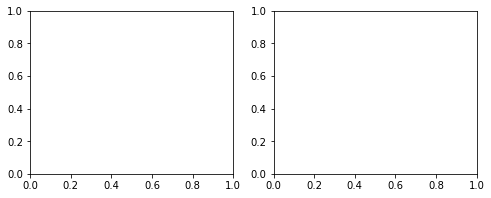

In [6]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))
# Test points every 0.02 in [0,1]

# Make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean()
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Define plotting function
def ax_plot():

    # Plot training data as black stars
    y1_ax.plot(train_x.detach().numpy(), train_y1.detach().numpy(), 'k*')
    # Predictive mean as blue line
    y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
    # Shade in confidence 
    y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
    y1_ax.set_ylim([-3, 3])
    y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y1_ax.set_title('Observed Values (Likelihood)')
    
    # Plot training data as black stars
    y2_ax.plot(train_x.detach().numpy(), train_y2.detach().numpy(), 'k*')
    # Predictive mean as blue line
    y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
    # Shade in confidence 
    y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
    y2_ax.set_ylim([-3, 3])
    y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y2_ax.set_title('Observed Values (Likelihood)')

# Plot both tasks
ax_plot()